In [1]:
from __future__ import division

from models import *
from utils.logger import *
from utils.utils import *
from utils.datasets import * 
from utils.parse_config import *
from test import evaluate

from terminaltables import AsciiTable

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

import os
import sys
import time
import datetime
from glob import glob
import csv

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Hyperparameter

In [3]:
params = {
    "epochs":200, #number of epochs
    "batch_size":8, #size of each image batch
    "log_interval":50, #interval train loss
    "cut_num":200, #cut number of batch size
    "gradient_accumulations":2, #number of gradient accums before step
    "model_def":"config/yolov3.cfg", #path to model definition file
    "data_config":"config/custom.data", #path to data config file
    "pretrained_weights":"weights/darknet53.conv.74", #if specified starts from checkpoint model
    "n_cpu":0, #number of cpu threads to use during batch generation
    "img_size":512, #size of each image dimension
    "checkpoint_interval":1, #interval between saving model weights
    "multiscale_training":True, #allow for multi-scale training
    "class_path":"data/custom/classes.names",
    "conf_thres":0.8,
    "nms_thres":0.4
}

# Model

In [4]:
model = Darknet(params["model_def"]).to(device)
model.apply(weights_init_normal)

optimizer = torch.optim.Adam(model.parameters())

In [5]:
if params["pretrained_weights"]:
    if params["pretrained_weights"].endswith(".pth"):
        model.load_state_dict(torch.load(params["pretrained_weights"]))
    else:
        model.load_darknet_weights(params["pretrained_weights"])

# Preprocess

In [6]:
data_config = parse_data_config(params["data_config"])
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

In [7]:
train_dataset = ListDataset(train_path, augment=True, multiscale=params["multiscale_training"])
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=params["batch_size"],
    shuffle=True,
    num_workers=params["n_cpu"],
    pin_memory=True,
    collate_fn=train_dataset.collate_fn,
)

val_dataset = ListDataset(valid_path, augment=True, multiscale=params["multiscale_training"])
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=params["n_cpu"],
    pin_memory=True,
    collate_fn=val_dataset.collate_fn,
)

# Visualization

In [8]:
def visualization(model, img_path):
    model.eval()
    classes = load_classes(params["class_path"])

    image = transforms.ToTensor()(Image.open(img_path).convert("RGB"))
    image = F.interpolate(image.unsqueeze(0), size=params["img_size"], mode="nearest").squeeze(0)
    
    with torch.no_grad():
        detections = model(image.unsqueeze(0).to(device))
        detections = non_max_suppression(detections, params["conf_thres"], params["nms_thres"])

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(Image.open(img_path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.set_title("Predicted BoundingBox Image")
    ax.axis('off')
    
    if detections[0] is not None:
        detections = rescale_boxes(detections[0], params["img_size"], img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
    
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_w = x2 - x1
            box_h = y2 - y1
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                       
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")

            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[0],
                color="white",
                verticalalignment="top", 
                bbox={"color": color, "pad": 0},
            )

<Figure size 432x288 with 0 Axes>

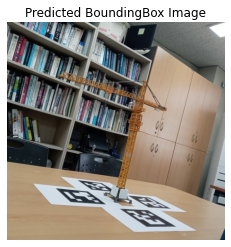

In [9]:
img_path = "C:/Users/IVCL/Desktop/crane/real_image/creal_0001.png"
visualization(model, img_path)

# Train

In [10]:
train_avg_losses = []
val_avg_losses = []

for epoch in range(1, params["epochs"]+1):
    model.train()
    train_losses = []
    val_losses = [] 
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(train_dataloader): 
        
        batches_done = len(train_dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % params["gradient_accumulations"]:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()
        
        train_losses.append(loss.item())
        
        if batch_i % params["log_interval"] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss: {:.4f}".format(
                epoch, params["epochs"], batch_i, params["cut_num"], loss.item()))
        
        if batch_i == params["cut_num"]:
            break

    train_avg_loss = torch.mean(torch.FloatTensor(train_losses))
    train_avg_losses.append(train_avg_loss.item())
    
    model.eval()
    with torch.no_grad():
        for batch_i, (_, imgs, targets) in enumerate(val_dataloader):   
            imgs = Variable(imgs.to(device))
            targets = Variable(targets.to(device), requires_grad=False)
            loss, outputs = model(imgs, targets)
            
            val_losses.append(loss.item())

    val_avg_loss = torch.mean(torch.FloatTensor(val_losses))
    val_avg_losses.append(val_avg_loss.item())
        
    print("Val_Loss: {:.4f}".format(val_avg_loss.item()))
        
    if epoch % params["checkpoint_interval"] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)

===> Epoch[1/200](0/200): Loss: 233.1555
===> Epoch[1/200](50/200): Loss: 22.9645
===> Epoch[1/200](100/200): Loss: 12.0876
===> Epoch[1/200](150/200): Loss: 11.4285
===> Epoch[1/200](200/200): Loss: 9.8844
Val_Loss: 10.1505
===> Epoch[2/200](0/200): Loss: 10.0688
===> Epoch[2/200](50/200): Loss: 8.1687
===> Epoch[2/200](100/200): Loss: 10.5514
===> Epoch[2/200](150/200): Loss: 6.7086
===> Epoch[2/200](200/200): Loss: 7.9716
Val_Loss: 11.2303
===> Epoch[3/200](0/200): Loss: 7.5257
===> Epoch[3/200](50/200): Loss: 9.6078
===> Epoch[3/200](100/200): Loss: 6.0759
===> Epoch[3/200](150/200): Loss: 5.8096
===> Epoch[3/200](200/200): Loss: 5.5105
Val_Loss: 6.5374
===> Epoch[4/200](0/200): Loss: 5.1591
===> Epoch[4/200](50/200): Loss: 5.1743
===> Epoch[4/200](100/200): Loss: 5.2283
===> Epoch[4/200](150/200): Loss: 7.0092
===> Epoch[4/200](200/200): Loss: 3.5279
Val_Loss: 6.9902
===> Epoch[5/200](0/200): Loss: 6.3862
===> Epoch[5/200](50/200): Loss: 3.7495
===> Epoch[5/200](100/200): Loss: 3.

===> Epoch[37/200](200/200): Loss: 2.8488
Val_Loss: 6.2409
===> Epoch[38/200](0/200): Loss: 2.4224
===> Epoch[38/200](50/200): Loss: 1.4499
===> Epoch[38/200](100/200): Loss: 1.2920
===> Epoch[38/200](150/200): Loss: 2.1903
===> Epoch[38/200](200/200): Loss: 2.4705
Val_Loss: 2.8077
===> Epoch[39/200](0/200): Loss: 0.9718
===> Epoch[39/200](50/200): Loss: 1.1736
===> Epoch[39/200](100/200): Loss: 3.1808
===> Epoch[39/200](150/200): Loss: 2.1769
===> Epoch[39/200](200/200): Loss: 1.5760
Val_Loss: 11.9755
===> Epoch[40/200](0/200): Loss: 1.7131
===> Epoch[40/200](50/200): Loss: 1.4050
===> Epoch[40/200](100/200): Loss: 2.0119
===> Epoch[40/200](150/200): Loss: 1.3405
===> Epoch[40/200](200/200): Loss: 1.5566
Val_Loss: 9.2624
===> Epoch[41/200](0/200): Loss: 1.7681
===> Epoch[41/200](50/200): Loss: 1.8398
===> Epoch[41/200](100/200): Loss: 1.2819
===> Epoch[41/200](150/200): Loss: 1.5118
===> Epoch[41/200](200/200): Loss: 2.0601
Val_Loss: 18.3823
===> Epoch[42/200](0/200): Loss: 1.5221
===

===> Epoch[74/200](100/200): Loss: 1.2752
===> Epoch[74/200](150/200): Loss: 0.9484
===> Epoch[74/200](200/200): Loss: 1.3278
Val_Loss: 36.5973
===> Epoch[75/200](0/200): Loss: 1.4404
===> Epoch[75/200](50/200): Loss: 1.1412
===> Epoch[75/200](100/200): Loss: 1.9959
===> Epoch[75/200](150/200): Loss: 1.0085
===> Epoch[75/200](200/200): Loss: 3.1239
Val_Loss: 37.8462
===> Epoch[76/200](0/200): Loss: 0.8499
===> Epoch[76/200](50/200): Loss: 1.1350
===> Epoch[76/200](100/200): Loss: 1.9507
===> Epoch[76/200](150/200): Loss: 1.4969
===> Epoch[76/200](200/200): Loss: 1.1850
Val_Loss: 28.1092
===> Epoch[77/200](0/200): Loss: 1.2385
===> Epoch[77/200](50/200): Loss: 1.5984
===> Epoch[77/200](100/200): Loss: 0.9036
===> Epoch[77/200](150/200): Loss: 1.1082
===> Epoch[77/200](200/200): Loss: 1.1271
Val_Loss: 3.3731
===> Epoch[78/200](0/200): Loss: 1.0044
===> Epoch[78/200](50/200): Loss: 1.0076
===> Epoch[78/200](100/200): Loss: 1.9022
===> Epoch[78/200](150/200): Loss: 1.2835
===> Epoch[78/200

===> Epoch[110/200](200/200): Loss: 0.6986
Val_Loss: 3.7006
===> Epoch[111/200](0/200): Loss: 1.5938
===> Epoch[111/200](50/200): Loss: 1.0714
===> Epoch[111/200](100/200): Loss: 0.7156
===> Epoch[111/200](150/200): Loss: 1.6771
===> Epoch[111/200](200/200): Loss: 0.6023
Val_Loss: 14.8460
===> Epoch[112/200](0/200): Loss: 0.8098
===> Epoch[112/200](50/200): Loss: 0.5933
===> Epoch[112/200](100/200): Loss: 1.2831
===> Epoch[112/200](150/200): Loss: 0.7966
===> Epoch[112/200](200/200): Loss: 0.9655
Val_Loss: 33.5853
===> Epoch[113/200](0/200): Loss: 1.3457
===> Epoch[113/200](50/200): Loss: 1.0809
===> Epoch[113/200](100/200): Loss: 1.2002
===> Epoch[113/200](150/200): Loss: 2.4179
===> Epoch[113/200](200/200): Loss: 1.0911
Val_Loss: 20.6829
===> Epoch[114/200](0/200): Loss: 0.5013
===> Epoch[114/200](50/200): Loss: 0.7050
===> Epoch[114/200](100/200): Loss: 1.5306
===> Epoch[114/200](150/200): Loss: 1.3809
===> Epoch[114/200](200/200): Loss: 1.0646
Val_Loss: 4.7534
===> Epoch[115/200](0

===> Epoch[146/200](150/200): Loss: 0.9637
===> Epoch[146/200](200/200): Loss: 0.7723
Val_Loss: 33.4825
===> Epoch[147/200](0/200): Loss: 0.7808
===> Epoch[147/200](50/200): Loss: 0.4564
===> Epoch[147/200](100/200): Loss: 0.9630
===> Epoch[147/200](150/200): Loss: 1.1599
===> Epoch[147/200](200/200): Loss: 0.4928
Val_Loss: 14.5478
===> Epoch[148/200](0/200): Loss: 0.7495
===> Epoch[148/200](50/200): Loss: 0.7247
===> Epoch[148/200](100/200): Loss: 1.1315
===> Epoch[148/200](150/200): Loss: 0.5556
===> Epoch[148/200](200/200): Loss: 1.7016
Val_Loss: 10.9290
===> Epoch[149/200](0/200): Loss: 0.3077
===> Epoch[149/200](50/200): Loss: 0.6543
===> Epoch[149/200](100/200): Loss: 1.1176
===> Epoch[149/200](150/200): Loss: 0.7954
===> Epoch[149/200](200/200): Loss: 0.7266
Val_Loss: 43.2699
===> Epoch[150/200](0/200): Loss: 0.6790
===> Epoch[150/200](50/200): Loss: 0.4704
===> Epoch[150/200](100/200): Loss: 0.5147
===> Epoch[150/200](150/200): Loss: 1.2486
===> Epoch[150/200](200/200): Loss: 0

===> Epoch[182/200](100/200): Loss: 0.5487
===> Epoch[182/200](150/200): Loss: 0.3517
===> Epoch[182/200](200/200): Loss: 0.6607
Val_Loss: 40.4477
===> Epoch[183/200](0/200): Loss: 0.4411
===> Epoch[183/200](50/200): Loss: 0.7559
===> Epoch[183/200](100/200): Loss: 2.1149
===> Epoch[183/200](150/200): Loss: 0.7360
===> Epoch[183/200](200/200): Loss: 0.4023
Val_Loss: 39.3034
===> Epoch[184/200](0/200): Loss: 0.8136
===> Epoch[184/200](50/200): Loss: 0.5812
===> Epoch[184/200](100/200): Loss: 0.8410
===> Epoch[184/200](150/200): Loss: 0.9465
===> Epoch[184/200](200/200): Loss: 0.5560
Val_Loss: 42.6681
===> Epoch[185/200](0/200): Loss: 0.9440
===> Epoch[185/200](50/200): Loss: 0.5733
===> Epoch[185/200](100/200): Loss: 1.6571
===> Epoch[185/200](150/200): Loss: 0.7701
===> Epoch[185/200](200/200): Loss: 0.4345
Val_Loss: 26.1845
===> Epoch[186/200](0/200): Loss: 0.5254
===> Epoch[186/200](50/200): Loss: 0.6268
===> Epoch[186/200](100/200): Loss: 0.3455
===> Epoch[186/200](150/200): Loss: 0

In [11]:
print('Minimum validation loss :',np.array(val_avg_losses).argmin()+1, "epoch")

Minimum validation loss : 38 epoch


# Loss Curve

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train_avg_losses, label='train')
plt.plot(val_avg_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [16]:
csvfile=open('../loss/train_loss_yolov3_nodr.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(train_avg_losses).reshape(len(train_avg_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

csvfile=open('../loss/val_loss_yolov3_nodr.csv','w', newline="")
csvwriter = csv.writer(csvfile)

for row in np.array(val_avg_losses).reshape(len(val_avg_losses),1):
    csvwriter.writerow(row)
    
csvfile.close()

# Restore Checkpoint 

In [11]:
model.load_state_dict(torch.load(f"checkpoints/DRX/yolov3_ckpt_21.pth"))

<All keys matched successfully>

# Test

In [12]:
model.eval()
precision, recall, AP, f1, ap_class = evaluate(
                model,
                path=valid_path,
                iou_thres=0.5,
                conf_thres=0.5,
                nms_thres=0.5,
                img_size=params["img_size"],
                batch_size=params["batch_size"],
            )

Computing AP: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [13]:
print("test_precision :",precision[0], "\ttest_recall :",recall[0], "\ttest AP :", AP[0], "\ttest_f1 :", f1[0], "\ntest_ap_class :", ap_class[0])

test_precision : 0.803030303030303 	test_recall : 0.7910447761194029 	test AP : 0.744289358874992 	test_f1 : 0.7969924812030075 
test_ap_class : 0


In [14]:
img_path = "C:/Users/IVCL/Desktop/crane/real_image/creal_0001.png"
visualization(model, img_path)

<Figure size 432x288 with 0 Axes>

<ipython-input-8-f3e1c8e9180a>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-8-f3e1c8e9180a>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<Figure size 432x288 with 0 Axes>

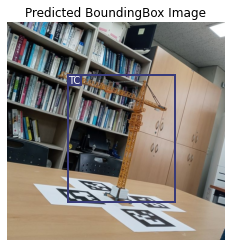

<Figure size 432x288 with 0 Axes>

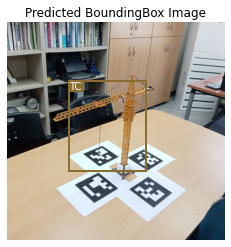

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

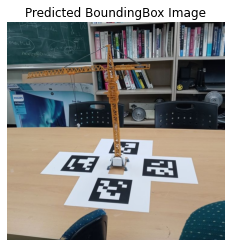

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

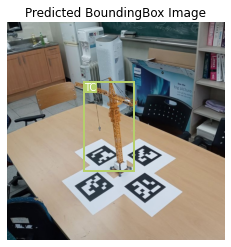

<Figure size 432x288 with 0 Axes>

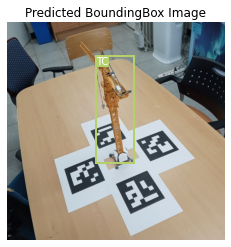

<Figure size 432x288 with 0 Axes>

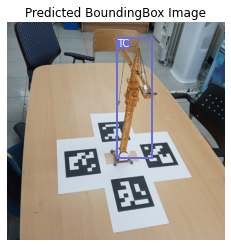

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

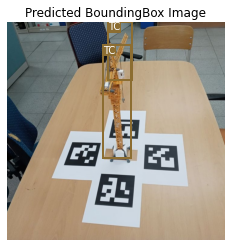

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

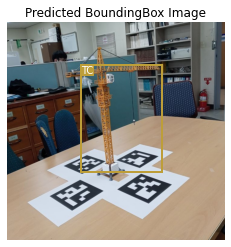

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

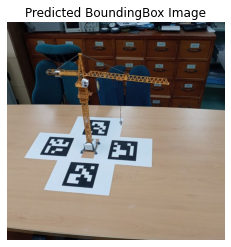

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

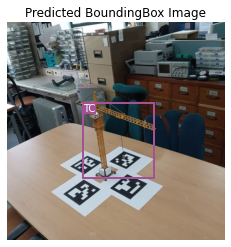

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

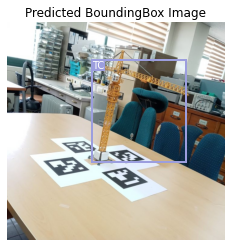

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

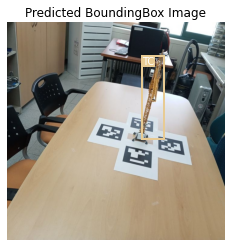

<Figure size 432x288 with 0 Axes>

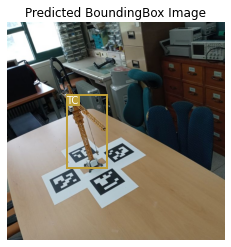

<Figure size 432x288 with 0 Axes>

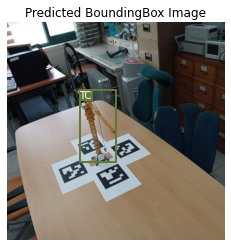

<Figure size 432x288 with 0 Axes>

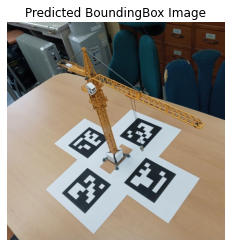

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

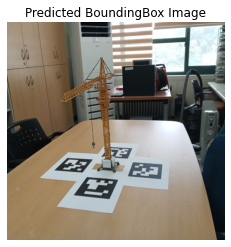

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

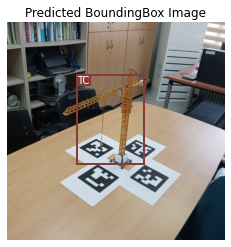

<Figure size 432x288 with 0 Axes>

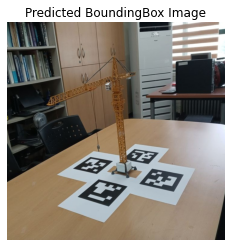

<Figure size 432x288 with 0 Axes>

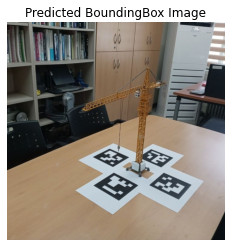

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

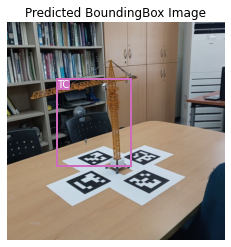

<Figure size 432x288 with 0 Axes>

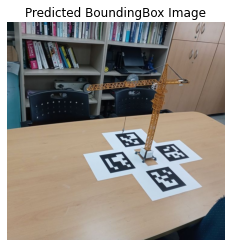

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

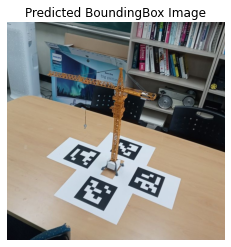

<Figure size 432x288 with 0 Axes>

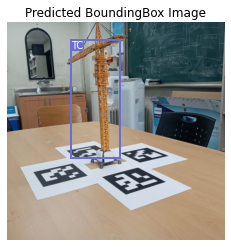

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

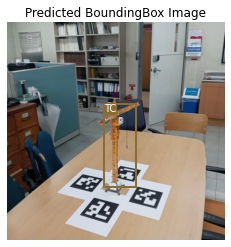

<Figure size 432x288 with 0 Axes>

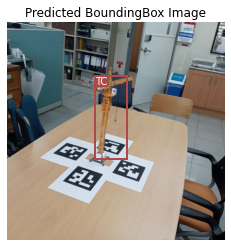

<Figure size 432x288 with 0 Axes>

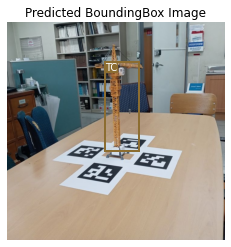

<Figure size 432x288 with 0 Axes>

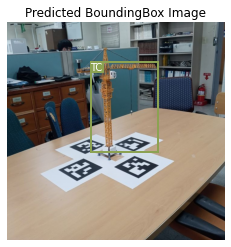

<Figure size 432x288 with 0 Axes>

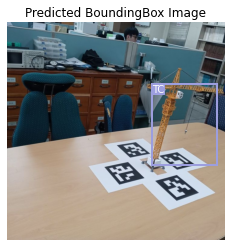

<Figure size 432x288 with 0 Axes>

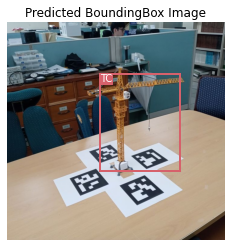

<Figure size 432x288 with 0 Axes>

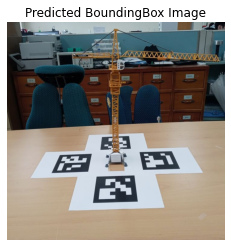

<Figure size 432x288 with 0 Axes>

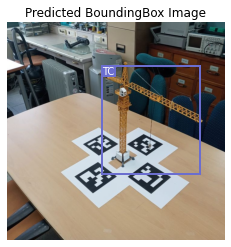

<Figure size 432x288 with 0 Axes>

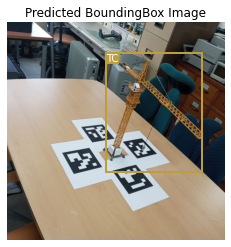

<Figure size 432x288 with 0 Axes>

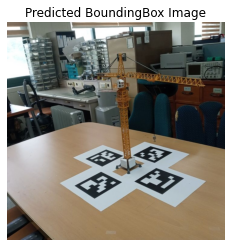

<Figure size 432x288 with 0 Axes>

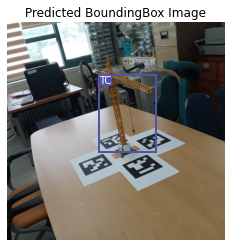

<Figure size 432x288 with 0 Axes>

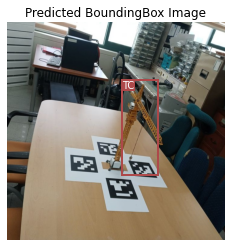

<Figure size 432x288 with 0 Axes>

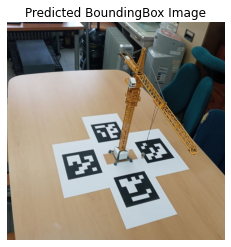

<Figure size 432x288 with 0 Axes>

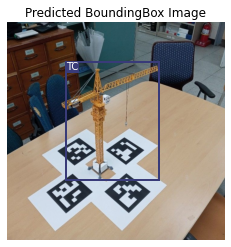

<Figure size 432x288 with 0 Axes>

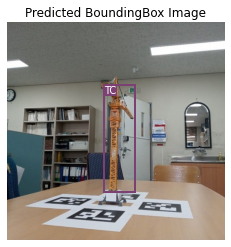

<Figure size 432x288 with 0 Axes>

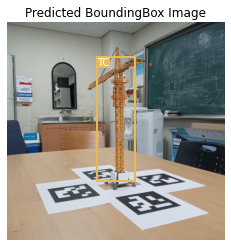

<Figure size 432x288 with 0 Axes>

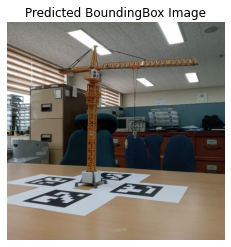

<Figure size 432x288 with 0 Axes>

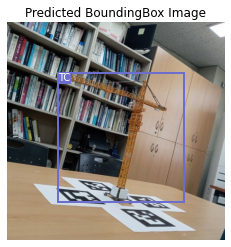

<Figure size 432x288 with 0 Axes>

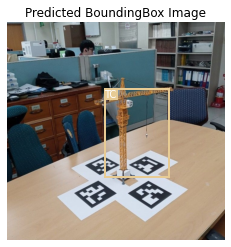

<Figure size 432x288 with 0 Axes>

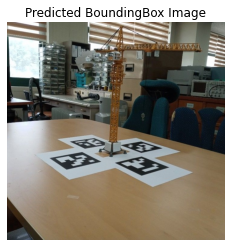

<Figure size 432x288 with 0 Axes>

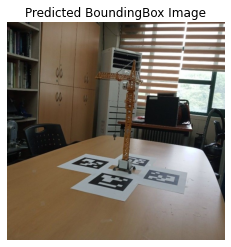

<Figure size 432x288 with 0 Axes>

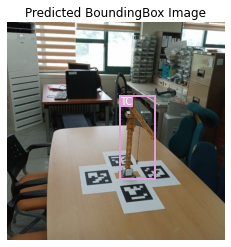

<Figure size 432x288 with 0 Axes>

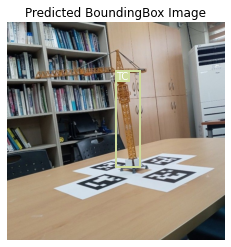

<Figure size 432x288 with 0 Axes>

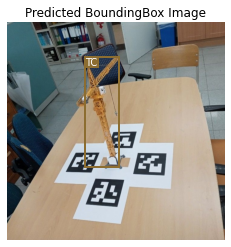

In [15]:
images = glob("C:/Users/IVCL/Desktop/crane/real_image/*.png")
for image in images:
    visualization(model, image)